# DMPS (Diffusion Map Particle System) on Torus T²

This notebook implements the **Diffusion Map Particle System (DMPS)** for particle evolution on a **Torus manifold**.

## Torus Parametrization

The torus $T^2$ is embedded in $\mathbb{R}^3$ using angles $(\theta, \phi) \in [0, 2\pi)^2$:

$$
\begin{aligned}
x &= (R + r\cos\phi)\cos\theta \\
y &= (R + r\cos\phi)\sin\theta \\
z &= r\sin\phi
\end{aligned}
$$

- $R$: Major radius (center to tube center)
- $r$: Minor radius (tube radius)

## Core Algorithm (DMPS)
- **Target Distribution**: Uniformly distributed points on torus $T^2$
- **Kernel Method**: Gaussian kernel + diffusion map normalization
- **Particle Evolution**: Gradient flow iteration via spectral method
- **Acceleration**: Supports GPU (CuPy) and CPU modes

## Comparison with Kernel EDMD
- **DMPS**: Uses Gaussian kernel directly on target samples
- **Kernel EDMD**: Learns Koopman operator from time-evolved data pairs $(X_t, X_{t+dt})$

## 1. Import Libraries and GPU/CPU Backend Configuration

In [1]:
import numpy as np
from scipy.linalg import svd, eigh
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import time

# --------------- Optional GPU backend (CuPy) ---------------
USE_GPU = True  # Set False to force CPU even if CuPy is available
try:
    import cupy as cp  # type: ignore
    GPU_AVAILABLE = True
except Exception:
    cp = None  # type: ignore
    GPU_AVAILABLE = False
USE_GPU = bool(USE_GPU and GPU_AVAILABLE)
if USE_GPU:
    from grad_ker1_gpu import grad_ker1
    from K_tar_eval_gpu import K_tar_eval
else:
    from grad_ker1 import grad_ker1
    from K_tar_eval import K_tar_eval

print(f"[DEVICE] {'GPU' if USE_GPU else 'CPU'} mode active")

[DEVICE] GPU mode active


## 2. Define Timing and Progress Utility Functions

In [2]:
# ---------------- Timing / Progress Utilities ----------------
def _fmt_secs(s: float) -> str:
    s = max(0.0, float(s))
    h = int(s // 3600)
    m = int((s % 3600) // 60)
    sec = int(s % 60)
    if h > 0:
        return f"{h:02d}:{m:02d}:{sec:02d}"
    return f"{m:02d}:{sec:02d}"

def _print_phase(name: str, t_start: float) -> float:
    dt = time.time() - t_start
    print(f"[TIMER] {name}: {dt:.3f}s")
    return time.time()

_LAST_PROGRESS_LEN = 0
def _print_progress(curr: int, total: int, start_time: float, prefix: str = "") -> None:
    global _LAST_PROGRESS_LEN
    total = max(1, int(total))
    curr = min(max(0, curr), total)
    bar_len = 30
    filled = int(bar_len * curr / total)
    filled = min(filled, bar_len)
    bar = ("=" * filled) + (">" if filled < bar_len else "") + ("." * max(0, bar_len - filled - (0 if filled == bar_len else 1)))
    pct = 100.0 * curr / total
    elapsed = time.time() - start_time
    avg = elapsed / max(1, curr)
    eta = avg * (total - curr)
    msg = f"{prefix}[{bar}] {pct:5.1f}% | iter {curr}/{total} | elapsed {_fmt_secs(elapsed)} | eta {_fmt_secs(eta)}"
    prev = _LAST_PROGRESS_LEN
    clear = "\r" + (" " * prev) + "\r"
    print(clear, end="")
    print(msg, end="", flush=True)
    _LAST_PROGRESS_LEN = len(msg)

# Set random seed for reproducibility
np.random.seed(42)
_t = time.time()

## 3. Configuration Parameters

- `R`: Major radius of the torus (center to tube center)
- `r`: Minor radius of the torus (tube radius)
- `n`: Number of target sample points
- `d`: Embedding dimension (3 for torus in R³)

In [3]:
# ---------------- Torus Configuration ----------------
R = 2.0   # Major radius (center to tube center)
r = 0.8   # Minor radius (tube radius), must satisfy r < R

# Number of target sample points
n = 800

d = 3  # Embedding dimension (torus lives in R³)

print(f"[CONFIG] Torus parameters: R={R}, r={r}")
print(f"[CONFIG] Number of samples: n={n}")

[CONFIG] Torus parameters: R=2.0, r=0.8
[CONFIG] Number of samples: n=800


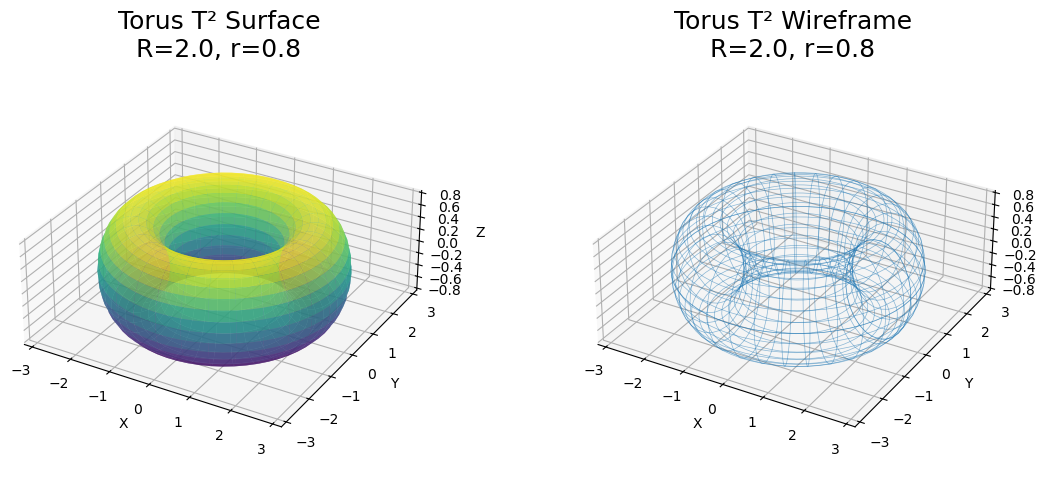

[INFO] Torus geometry: Major radius R=2.0, Minor radius r=0.8
[INFO] Torus extends from x,y ∈ [-2.8, 2.8], z ∈ [-0.8, 0.8]


In [4]:
# Visualize the torus surface
fig = plt.figure(figsize=(12, 5))

# Create mesh grid for torus surface
theta_mesh = np.linspace(0, 2 * np.pi, 60)
phi_mesh = np.linspace(0, 2 * np.pi, 30)
THETA, PHI = np.meshgrid(theta_mesh, phi_mesh)

# Parametric equations for torus
X_mesh = (R + r * np.cos(PHI)) * np.cos(THETA)
Y_mesh = (R + r * np.cos(PHI)) * np.sin(THETA)
Z_mesh = r * np.sin(PHI)

# Plot 1: Surface plot
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(X_mesh, Y_mesh, Z_mesh, cmap='viridis', alpha=0.7, edgecolor='none')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_title(f'Torus T² Surface\nR={R}, r={r}', fontsize=18)
ax1.set_box_aspect([1, 1, 0.4])

# Plot 2: Wireframe plot (shows structure better)
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_wireframe(X_mesh, Y_mesh, Z_mesh, color='C0', alpha=0.5, linewidth=0.5)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax2.set_title(f'Torus T² Wireframe\nR={R}, r={r}', fontsize=18)
ax2.set_box_aspect([1, 1, 0.4])

plt.tight_layout()
plt.show()

print(f"[INFO] Torus geometry: Major radius R={R}, Minor radius r={r}")
print(f"[INFO] Torus extends from x,y ∈ [{-(R+r):.1f}, {R+r:.1f}], z ∈ [{-r:.1f}, {r:.1f}]")

## 4. Torus Helper Functions

Define functions to:
1. Convert between angular coordinates $(\theta, \phi)$ and Cartesian $(x, y, z)$
2. Compute tangent vectors and normal vectors on the torus

In [5]:
def angles_to_cartesian(theta, phi, R, r):
    """
    Convert angular coordinates (theta, phi) to Cartesian (x, y, z).
    
    Parameters:
        theta: array of shape (n,) - angle around the major circle [0, 2π)
        phi: array of shape (n,) - angle around the minor circle [0, 2π)
        R: major radius
        r: minor radius
    
    Returns:
        X: array of shape (n, 3) - Cartesian coordinates
    """
    x = (R + r * np.cos(phi)) * np.cos(theta)
    y = (R + r * np.cos(phi)) * np.sin(theta)
    z = r * np.sin(phi)
    return np.column_stack([x, y, z])

def cartesian_to_angles(X, R, r):
    """
    Convert Cartesian coordinates (x, y, z) back to angular (theta, phi).
    
    Parameters:
        X: array of shape (n, 3) - Cartesian coordinates
        R: major radius
        r: minor radius
    
    Returns:
        theta: array of shape (n,) - angle around major circle [0, 2π)
        phi: array of shape (n,) - angle around minor circle [0, 2π)
    """
    x, y, z = X[:, 0], X[:, 1], X[:, 2]
    theta = np.arctan2(y, x)
    theta = np.mod(theta, 2 * np.pi)  # Ensure [0, 2π)
    
    # Distance from z-axis
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(z, rho - R)
    phi = np.mod(phi, 2 * np.pi)  # Ensure [0, 2π)
    
    return theta, phi

def project_to_torus(X, R, r):
    """
    Project points in R³ onto the nearest point on the torus surface.
    
    This is used for numerical stability after Euler-Maruyama updates.
    """
    # Convert to angles and back
    theta, phi = cartesian_to_angles(X, R, r)
    return angles_to_cartesian(theta, phi, R, r)

## 5. Generate Target Distribution Samples (X_tar)

Sample uniformly on the torus $T^2$. The uniform measure on torus is:
$$
d\mu = (R + r\cos\phi) \, d\theta \, d\phi
$$

We use rejection sampling to account for the $(R + r\cos\phi)$ factor.

In [6]:
# Uniform sampling on torus using rejection sampling
# The density is proportional to (R + r*cos(phi))

samples_theta = []
samples_phi = []
max_density = R + r  # Maximum value of (R + r*cos(phi))

while len(samples_theta) < n:
    # Propose uniform angles
    batch_size = int((n - len(samples_theta)) * 1.5) + 100
    theta_prop = np.random.uniform(0, 2 * np.pi, batch_size)
    phi_prop = np.random.uniform(0, 2 * np.pi, batch_size)
    
    # Accept with probability proportional to (R + r*cos(phi)) / max_density
    density = R + r * np.cos(phi_prop)
    accept_prob = density / max_density
    u = np.random.uniform(0, 1, batch_size)
    accept = u < accept_prob
    
    samples_theta.extend(theta_prop[accept])
    samples_phi.extend(phi_prop[accept])

# Take exactly n samples
theta_tar = np.array(samples_theta[:n])
phi_tar = np.array(samples_phi[:n])

# Convert to Cartesian coordinates
X_tar = angles_to_cartesian(theta_tar, phi_tar, R, r)
_t = _print_phase(f"Target sample generation (uniform on torus)", _t)
print(f"[INFO] Generated {n} uniformly distributed points on torus T²")
print(f"[INFO] X_tar shape: {X_tar.shape}, range: [{X_tar.min():.2f}, {X_tar.max():.2f}]")

[TIMER] Target sample generation (uniform on torus): 0.234s
[INFO] Generated 800 uniformly distributed points on torus T²
[INFO] X_tar shape: (800, 3), range: [-2.78, 2.79]


[SAVED] Interactive 3D plot saved to: figures/torus/X_tar_torus_interactive.html


c:\Users\xyc93\miniconda3\envs\gpu\Lib\site-packages\plotly\offline\offline.py:152: UserWarning:


Unrecognized config options supplied: ['mathjax']



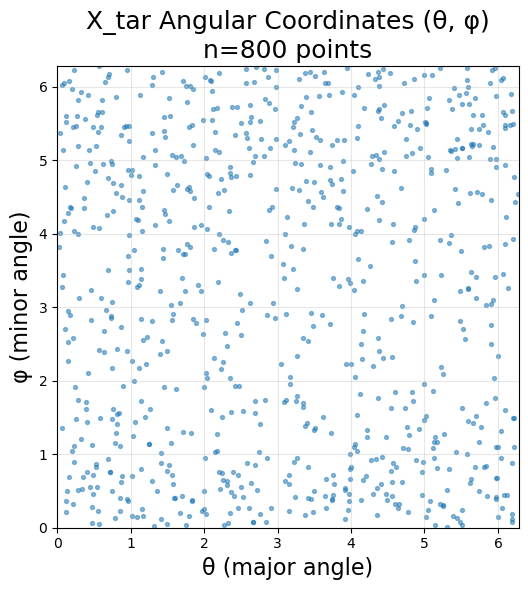


[INFO] In angular space, density ∝ (R + r·cos(φ))
[INFO] Outer edge (φ≈0): higher density | Inner edge (φ≈π): lower density


In [7]:
# Visualize X_tar uniform distribution on torus
import plotly.graph_objects as go
import os

# ============ Plot 1: Interactive 3D scatter (Plotly - can rotate!) ============
# Create torus surface mesh for reference
theta_surf = np.linspace(0, 2 * np.pi, 50)
phi_surf = np.linspace(0, 2 * np.pi, 30)
THETA_S, PHI_S = np.meshgrid(theta_surf, phi_surf)
X_surf = (R + r * np.cos(PHI_S)) * np.cos(THETA_S)
Y_surf = (R + r * np.cos(PHI_S)) * np.sin(THETA_S)
Z_surf = r * np.sin(PHI_S)

fig_3d = go.Figure()

# Add torus surface (semi-transparent)
fig_3d.add_trace(go.Surface(
    x=X_surf, y=Y_surf, z=Z_surf,
    opacity=0.3,
    colorscale='Viridis',
    showscale=False,
    name='Torus Surface'
))

# Add X_tar scatter points
fig_3d.add_trace(go.Scatter3d(
    x=X_tar[:, 0], y=X_tar[:, 1], z=X_tar[:, 2],
    mode='markers',
    marker=dict(size=3, color='blue', opacity=0.7),
    name=f'X_tar (n={n})'
))

# Build title
title_text = f'X_tar: Uniform Distribution on Torus 𝕋² (n={n}) | R={R}, r={r}'
fig_3d.update_layout(
    title=dict(
        text=title_text,
        font=dict(size=16)
    ),
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z',
        aspectmode='data'
    ),
    width=800,
    height=600
)

# Save interactive HTML file
os.makedirs('figures/torus', exist_ok=True)
html_path = 'figures/torus/X_tar_torus_interactive.html'
fig_3d.write_html(html_path, include_mathjax='cdn')
print(f"[SAVED] Interactive 3D plot saved to: {html_path}")

# Display in notebook
try:
    fig_3d.show(config={'mathjax': 'cdn'})
except Exception as e:
    print(f"[INFO] Cannot display interactive plot in notebook: {e}")
    print(f"[INFO] Please open the HTML file in browser: {html_path}")

# ============ Plot 2: Angular coordinates (θ, φ) - Matplotlib ============
fig2, ax2 = plt.subplots(figsize=(7, 6))
ax2.scatter(theta_tar, phi_tar, s=8, c='C0', alpha=0.5)
ax2.set_xlabel('θ (major angle)', fontsize=16)
ax2.set_ylabel('φ (minor angle)', fontsize=16)
ax2.set_xlim(0, 2*np.pi)
ax2.set_ylim(0, 2*np.pi)
ax2.set_aspect('equal')
ax2.set_title(f'X_tar Angular Coordinates (θ, φ)\nn={n} points', fontsize=18)
ax2.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n[INFO] In angular space, density ∝ (R + r·cos(φ))")
print(f"[INFO] Outer edge (φ≈0): higher density | Inner edge (φ≈π): lower density")

## 6. Build Gaussian Kernel Matrix and Normalization (DMPS)

Steps:
1. Compute Euclidean distances between sample points
2. Adaptively determine bandwidth parameter `epsilon`
3. Build Gaussian kernel matrix
4. Density normalization
5. Random-walk symmetric normalization

In [8]:
# Form the anisotropic graph Laplacian
sq_tar = np.sum(X_tar ** 2, axis=1)
H = sq_tar[:, None] + sq_tar[None, :] - 2 * (X_tar @ X_tar.T)
H = np.maximum(H, 0)  # Numerical stability

# Bandwidth parameter (adaptive based on median heuristic)
epsilon = 0.5 * np.median(H) / (np.log(n + 1) + 1e-12)
print(f"[KERNEL] Bandwidth epsilon = {epsilon:.6f}")

def ker(X):
    sq = np.sum(X ** 2, axis=1)
    return np.exp(-(sq[:, None] + sq[None, :] - 2 * (X @ X.T)) / (2 * epsilon))

data_kernel = ker(X_tar)
_t = _print_phase("Base kernel (Gaussian) build", _t)

# Density normalization
p_x = np.sqrt(np.sum(data_kernel, axis=1))
p_y = p_x.copy()
data_kernel_norm = data_kernel / p_x[:, None] / p_y[None, :]
D_y = np.sum(data_kernel_norm, axis=0)

# Random-walk symmetric normalization
rw_kernel = 0.5 * (data_kernel_norm / D_y + data_kernel_norm / D_y[:, None])
_t = _print_phase("Random-walk symmetric normalization", _t)

[KERNEL] Bandwidth epsilon = 0.684265
[TIMER] Base kernel (Gaussian) build: 0.285s
[TIMER] Random-walk symmetric normalization: 0.006s


## 7. SVD Decomposition and Inverse Kernel Computation

Extract spectral information from the kernel matrix via singular value decomposition, and compute regularized inverse weights for gradient calculations.

In [9]:
phi, s, _ = svd(rw_kernel)
_t = _print_phase("SVD on rw_kernel", _t)

lambda_ns = s
lambda_ = -lambda_ns + 1
inv_lambda = np.zeros_like(lambda_)
inv_lambda[1:] = 1 / lambda_[1:]
inv_lambda = inv_lambda * epsilon
inv_K = phi @ np.diag(inv_lambda) @ phi.T
_t = _print_phase("Primary inverse-like weights (inv_lambda)", _t)

tol = 1e-6
lambda_ns_mod = np.copy(lambda_ns)
lambda_ns_mod[lambda_ns_mod < tol] = 0
below_tol = np.sum(lambda_ns < tol)
above_tol = n - below_tol
reg = 0.001
lambda_ns_inv = np.zeros_like(lambda_ns)
mask = lambda_ns >= tol
lambda_ns_inv[mask] = epsilon / (lambda_ns[mask] + reg)
inv_K_ns = phi @ np.diag(lambda_ns_inv) @ phi.T
_t = _print_phase("Regularized inverse weights (lambda_ns_inv)", _t)

[TIMER] SVD on rw_kernel: 0.131s
[TIMER] Primary inverse-like weights (inv_lambda): 0.006s
[TIMER] Regularized inverse weights (lambda_ns_inv): 0.006s


## 8. Eigenvalue Analysis


[EIGENVALUE ANALYSIS]
Total eigenvalues: 800
Largest eigenvalue: 1.000170
Smallest eigenvalue: 8.271648e-18
Eigenvalues > 1.0: 1
Eigenvalues < 0.0: 0
Eigenvalues in [0, 1e-06): 543
Eigenvalues in [1e-06, 1.0]: 256

First 10 eigenvalues:
  λ[0] = 1.00016990
  λ[1] = 0.91056258
  λ[2] = 0.90238835
  λ[3] = 0.72908215
  λ[4] = 0.70404429
  λ[5] = 0.53590883
  λ[6] = 0.50432966
  λ[7] = 0.43119594
  λ[8] = 0.40410935
  λ[9] = 0.39168774



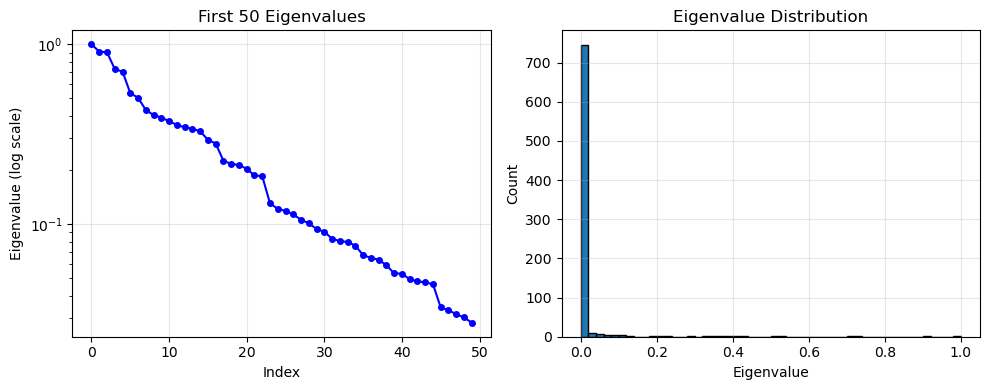

In [10]:
print("\n[EIGENVALUE ANALYSIS]")
print(f"Total eigenvalues: {len(lambda_ns)}")
print(f"Largest eigenvalue: {lambda_ns[0]:.6f}")
print(f"Smallest eigenvalue: {lambda_ns[-1]:.6e}")

count_gt_1 = np.sum(lambda_ns > 1.0)
print(f"Eigenvalues > 1.0: {count_gt_1}")

count_lt_0 = np.sum(lambda_ns < 0.0)
print(f"Eigenvalues < 0.0: {count_lt_0}")

tol_small = 1e-6
count_near_0 = np.sum((lambda_ns >= 0.0) & (lambda_ns < tol_small))
print(f"Eigenvalues in [0, {tol_small:.0e}): {count_near_0}")

count_tiny_to_1 = np.sum((lambda_ns >= tol_small) & (lambda_ns <= 1.0))
print(f"Eigenvalues in [{tol_small:.0e}, 1.0]: {count_tiny_to_1}")

print(f"\nFirst 10 eigenvalues:")
for i in range(min(10, len(lambda_ns))):
    print(f"  λ[{i}] = {lambda_ns[i]:.8f}")
print("=" * 60 + "\n")

# Plot eigenvalue spectrum
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.semilogy(lambda_ns[:50], 'bo-', markersize=4)
plt.xlabel('Index')
plt.ylabel('Eigenvalue (log scale)')
plt.title('First 50 Eigenvalues')
plt.grid(True, alpha=0.3)

plt.subplot(122)
plt.hist(lambda_ns, bins=50, edgecolor='black')
plt.xlabel('Eigenvalue')
plt.ylabel('Count')
plt.title('Eigenvalue Distribution')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 9. Particle Initialization

Initialize particles in a **localized region** of the torus to observe diffusion.

We place particles near the "top" of the torus tube (φ ≈ π/2) and at a specific θ location.

In [35]:
# DMPS parameters
num_iter = 5000
h = 0.005  # Step size
m_init = 2000  # Initial number of particles to generate

# Initialize particles in a local region of the torus
# Location: near θ ≈ 0 and φ ≈ π/2 (top of the tube, front of the torus)
theta_init_center = 0.0
phi_init_center = np.pi / 2  # Top of the tube

# Generate particles with small spread around the center
theta_spread = 0.3  # Spread in θ direction
phi_spread = 0.3    # Spread in φ direction

theta_init = theta_init_center + np.random.uniform(-theta_spread, theta_spread, m_init)
phi_init = phi_init_center + np.random.uniform(-phi_spread, phi_spread, m_init)

# Wrap to [0, 2π)
theta_init = np.mod(theta_init, 2 * np.pi)
phi_init = np.mod(phi_init, 2 * np.pi)

# Convert to Cartesian
x_init = angles_to_cartesian(theta_init, phi_init, R, r)
m = x_init.shape[0]

print(f"[INFO] Initialized {m} particles in local region:")
print(f"       θ ∈ [{theta_init.min():.2f}, {theta_init.max():.2f}] (center: {theta_init_center:.2f})")
print(f"       φ ∈ [{phi_init.min():.2f}, {phi_init.max():.2f}] (center: {phi_init_center:.2f})")

# Initialize trajectory storage
x_t = np.zeros((m, d, num_iter), dtype=np.float64)
x_t[:, :, 0] = x_init

# Precompute quantities for DMPS
p_tar = np.sum(data_kernel, axis=0)
D = np.sum(data_kernel / np.sqrt(p_tar) / np.sqrt(p_tar)[:, None], axis=1)

inv_K_ns_s_ns = phi @ np.diag(lambda_ns_inv * inv_lambda * lambda_ns_inv) @ phi.T
lambda_s_s_ns = inv_lambda * inv_lambda * lambda_ns_inv
lambda_s_s_ns = lambda_s_s_ns[:above_tol]
lambda_ns_s_ns = lambda_ns_inv * inv_lambda * lambda_ns_inv
lambda_ns_s_ns = lambda_ns_s_ns[:above_tol]

print(f"\nNumber of particles: {m}")
print(f"Effective eigenvalues: {above_tol} / {n}")

[INFO] Initialized 2000 particles in local region:
       θ ∈ [0.00, 6.28] (center: 0.00)
       φ ∈ [1.27, 1.87] (center: 1.57)

Number of particles: 2000
Effective eigenvalues: 257 / 800


## 10. DMPS Iteration Loop

Core algorithm: $x_{t+1} = x_t - \frac{h}{m} \nabla K(x_t, X_{tar})$

Supports both GPU and CPU modes with progress bar display.

In [36]:
sum_x = np.zeros((m, d))
loop_start = time.time()
total_loop = num_iter - 1

if USE_GPU:
    # Stage constants on GPU (keep float64 for precision)
    X_tar_gpu = cp.asarray(X_tar)
    p_tar_gpu = cp.asarray(p_tar)
    sq_tar_gpu = cp.asarray(sq_tar)
    D_gpu = cp.asarray(D)
    phi_gpu = cp.asarray(phi[:, :above_tol])
    lambda_ns_s_ns_gpu = cp.asarray(lambda_ns_s_ns)
    x_t_gpu = cp.asarray(x_t)
    diag_lambda_gpu = cp.diag(lambda_ns_s_ns_gpu)
    
    # Iteration loop (GPU)
    for t in range(num_iter - 1):
        x_slice = x_t_gpu[:, :, t]
        grad_matrix = grad_ker1(x_slice, X_tar_gpu, p_tar_gpu, sq_tar_gpu, D_gpu, epsilon)
        cross_matrix = K_tar_eval(X_tar_gpu, x_slice, p_tar_gpu, sq_tar_gpu, D_gpu, epsilon)
        
        sum_x_gpu = cp.zeros((m, d))
        for i in range(d):
            sum_x_gpu[:, i] = cp.sum(
                grad_matrix[:, :, i] @ phi_gpu @ diag_lambda_gpu @ phi_gpu.T @ cross_matrix,
                axis=1
            )
        
        x_t_gpu[:, :, t + 1] = x_slice - (h / m) * sum_x_gpu
        done = t + 1
        if done == total_loop or (done % max(1, total_loop // 100) == 0):
            _print_progress(done, total_loop, loop_start, prefix="[DMPS-TORUS-GPU] ")
    
    x_t = cp.asnumpy(x_t_gpu)
else:
    # CPU iteration loop
    for t in range(num_iter - 1):
        grad_matrix = grad_ker1(x_t[:, :, t], X_tar, p_tar, sq_tar, D, epsilon)
        cross_matrix = K_tar_eval(X_tar, x_t[:, :, t], p_tar, sq_tar, D, epsilon)
        for i in range(d):
            sum_x[:, i] = np.sum(
                grad_matrix[:, :, i] @ phi[:, :above_tol] @ np.diag(lambda_ns_s_ns) @ phi[:, :above_tol].T @ cross_matrix,
                axis=1
            )
        x_t[:, :, t + 1] = x_t[:, :, t] - h / m * sum_x
        done = t + 1
        if done == total_loop or (done % max(1, total_loop // 100) == 0):
            _print_progress(done, total_loop, loop_start, prefix="[DMPS-TORUS-CPU] ")

print()
_t = _print_phase("Iteration loop total", loop_start)

[DMPS-TORUS-GPU] [==============================] 100.0% | iter 4999/4999 | elapsed 07:04 | eta 00:00
[TIMER] Iteration loop total: 425.777s


## 11. Visualize Results (3D)

- **Blue dots**: Target distribution (uniform on torus)
- **Red solid circles**: Initial particle positions (localized)
- **Magenta hollow circles**: Final particle positions (should spread out)

[SAVED] figures/torus/dmps_1_target.pdf & .png


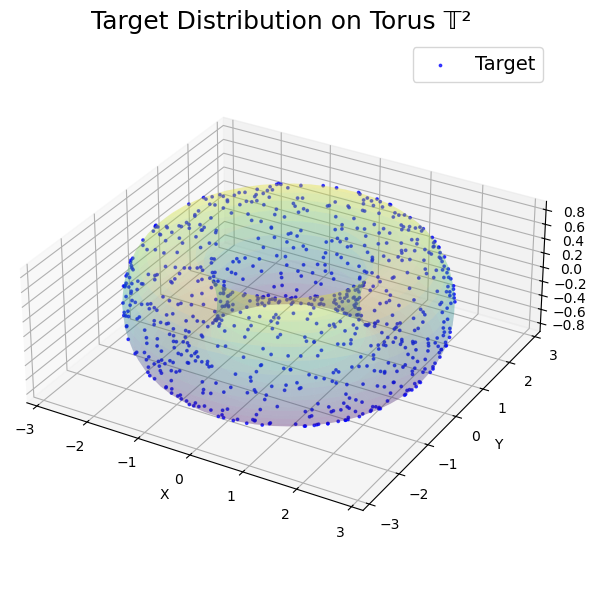

DMPS Method, n=800
[SAVED] figures/torus/dmps_2_initial.pdf & .png


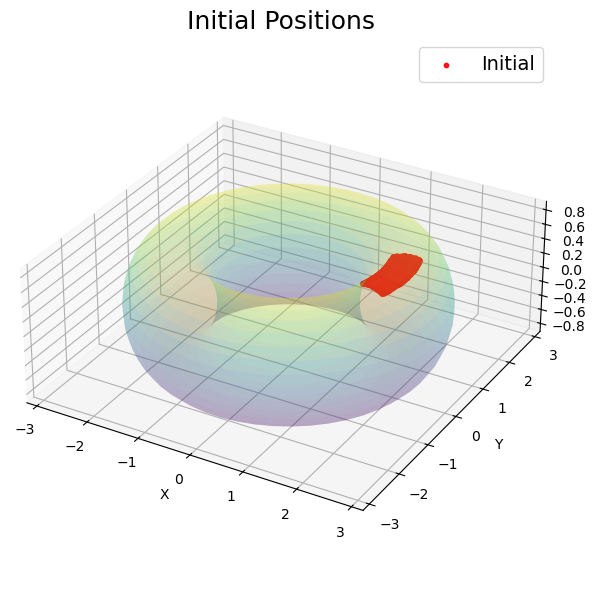

m=2000 particles
[SAVED] figures/torus/dmps_3_final.pdf & .png


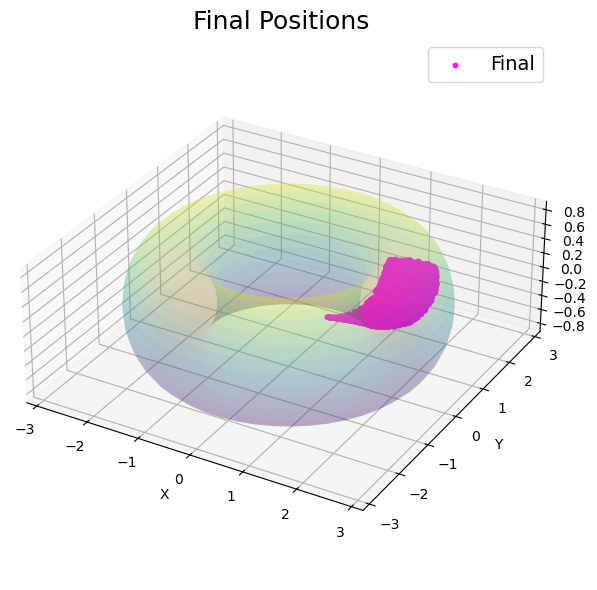

after 5000 iterations


In [37]:
# Create torus surface mesh for reference
theta_surf = np.linspace(0, 2 * np.pi, 50)
phi_surf = np.linspace(0, 2 * np.pi, 30)
THETA_S, PHI_S = np.meshgrid(theta_surf, phi_surf)
X_surf = (R + r * np.cos(PHI_S)) * np.cos(THETA_S)
Y_surf = (R + r * np.cos(PHI_S)) * np.sin(THETA_S)
Z_surf = r * np.sin(PHI_S)

# ============ Figure 1: Target distribution only ============
fig1 = plt.figure(figsize=(8, 6))
ax1 = fig1.add_subplot(111, projection='3d')
ax1.plot_surface(X_surf, Y_surf, Z_surf, alpha=0.2, cmap='viridis', edgecolor='none')
ax1.scatter(X_tar[:, 0], X_tar[:, 1], X_tar[:, 2], s=3, c='blue', alpha=0.7, label='Target')
ax1.set_title('Target Distribution on Torus 𝕋²', fontsize=18)
ax1.legend(fontsize=14)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_box_aspect([1, 1, 0.4])
plt.tight_layout()
plt.savefig('figures/torus/dmps_1_target.pdf', dpi=300, bbox_inches='tight')
plt.savefig('figures/torus/dmps_1_target.png', dpi=300, bbox_inches='tight')
print("[SAVED] figures/torus/dmps_1_target.pdf & .png")
plt.show()
print(f'DMPS Method, n={n}')

# ============ Figure 2: Initial positions only ============
fig2 = plt.figure(figsize=(8, 6))
ax2 = fig2.add_subplot(111, projection='3d')
ax2.plot_surface(X_surf, Y_surf, Z_surf, alpha=0.2, cmap='viridis', edgecolor='none')
ax2.scatter(x_t[:, 0, 0], x_t[:, 1, 0], x_t[:, 2, 0], s=10, c='red', alpha=0.9, label='Initial')
ax2.set_title('Initial Positions', fontsize=18)
ax2.legend(fontsize=14)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax2.set_box_aspect([1, 1, 0.4])
plt.tight_layout()
plt.savefig('figures/torus/dmps_2_initial.pdf', dpi=300, bbox_inches='tight')
plt.savefig('figures/torus/dmps_2_initial.png', dpi=300, bbox_inches='tight')
print("[SAVED] figures/torus/dmps_2_initial.pdf & .png")
plt.show()
print(f'm={m} particles')

# ============ Figure 3: Final positions only ============
fig3 = plt.figure(figsize=(8, 6))
ax3 = fig3.add_subplot(111, projection='3d')
ax3.plot_surface(X_surf, Y_surf, Z_surf, alpha=0.2, cmap='viridis', edgecolor='none')
ax3.scatter(x_t[:, 0, -1], x_t[:, 1, -1], x_t[:, 2, -1], s=10, c='magenta', alpha=0.9, label='Final')
ax3.set_title('Final Positions', fontsize=18)
ax3.legend(fontsize=14)
ax3.set_xlabel('X')
ax3.set_ylabel('Y')
ax3.set_zlabel('Z')
ax3.set_box_aspect([1, 1, 0.4])
plt.tight_layout()
plt.savefig('figures/torus/dmps_3_final.pdf', dpi=300, bbox_inches='tight')
plt.savefig('figures/torus/dmps_3_final.png', dpi=300, bbox_inches='tight')
print("[SAVED] figures/torus/dmps_3_final.pdf & .png")
plt.show()
print(f'after {num_iter} iterations')

In [38]:
# ============ Interactive Plotly 3D Plots (can rotate!) ============
import plotly.graph_objects as go

# Create torus surface mesh for Plotly
theta_surf_p = np.linspace(0, 2 * np.pi, 50)
phi_surf_p = np.linspace(0, 2 * np.pi, 30)
THETA_P, PHI_P = np.meshgrid(theta_surf_p, phi_surf_p)
X_surf_p = (R + r * np.cos(PHI_P)) * np.cos(THETA_P)
Y_surf_p = (R + r * np.cos(PHI_P)) * np.sin(THETA_P)
Z_surf_p = r * np.sin(PHI_P)

# ============ Interactive Figure 1: Initial positions ============
fig_init = go.Figure()
fig_init.add_trace(go.Surface(
    x=X_surf_p, y=Y_surf_p, z=Z_surf_p,
    opacity=0.3, colorscale='Viridis', showscale=False, name='Torus'
))
fig_init.add_trace(go.Scatter3d(
    x=x_t[:, 0, 0], y=x_t[:, 1, 0], z=x_t[:, 2, 0],
    mode='markers', marker=dict(size=3, color='red', opacity=0.9),
    name=f'Initial (m={m})'
))
fig_init.update_layout(
    title=f'DMPS: Initial Particle Positions | m={m} particles',
    scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z', aspectmode='data'),
    width=800, height=600
)
fig_init.write_html('figures/torus/dmps_initial_interactive.html', include_mathjax='cdn')
print("[SAVED] figures/torus/dmps_initial_interactive.html")
fig_init.show()

# ============ Interactive Figure 2: Final positions ============
fig_final = go.Figure()
fig_final.add_trace(go.Surface(
    x=X_surf_p, y=Y_surf_p, z=Z_surf_p,
    opacity=0.3, colorscale='Viridis', showscale=False, name='Torus'
))
fig_final.add_trace(go.Scatter3d(
    x=x_t[:, 0, -1], y=x_t[:, 1, -1], z=x_t[:, 2, -1],
    mode='markers', marker=dict(size=3, color='magenta', opacity=0.9),
    name=f'Final (iter={num_iter})'
))
# Also add target for comparison (semi-transparent)
fig_final.add_trace(go.Scatter3d(
    x=X_tar[:, 0], y=X_tar[:, 1], z=X_tar[:, 2],
    mode='markers', marker=dict(size=2, color='blue', opacity=0.3),
    name=f'Target (n={n})'
))
fig_final.update_layout(
    title=f'DMPS: Final Positions after {num_iter} iterations',
    scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z', aspectmode='data'),
    width=800, height=600
)
fig_final.write_html('figures/torus/dmps_final_interactive.html', include_mathjax='cdn')
print("[SAVED] figures/torus/dmps_final_interactive.html")
fig_final.show()
print(f'DMPS Method')

[SAVED] figures/torus/dmps_initial_interactive.html


[SAVED] figures/torus/dmps_final_interactive.html


DMPS Method


[SAVED] figures/torus/dmps_torus_results.pdf (vector format for LaTeX)
[SAVED] figures/torus/dmps_torus_results.png (raster format)


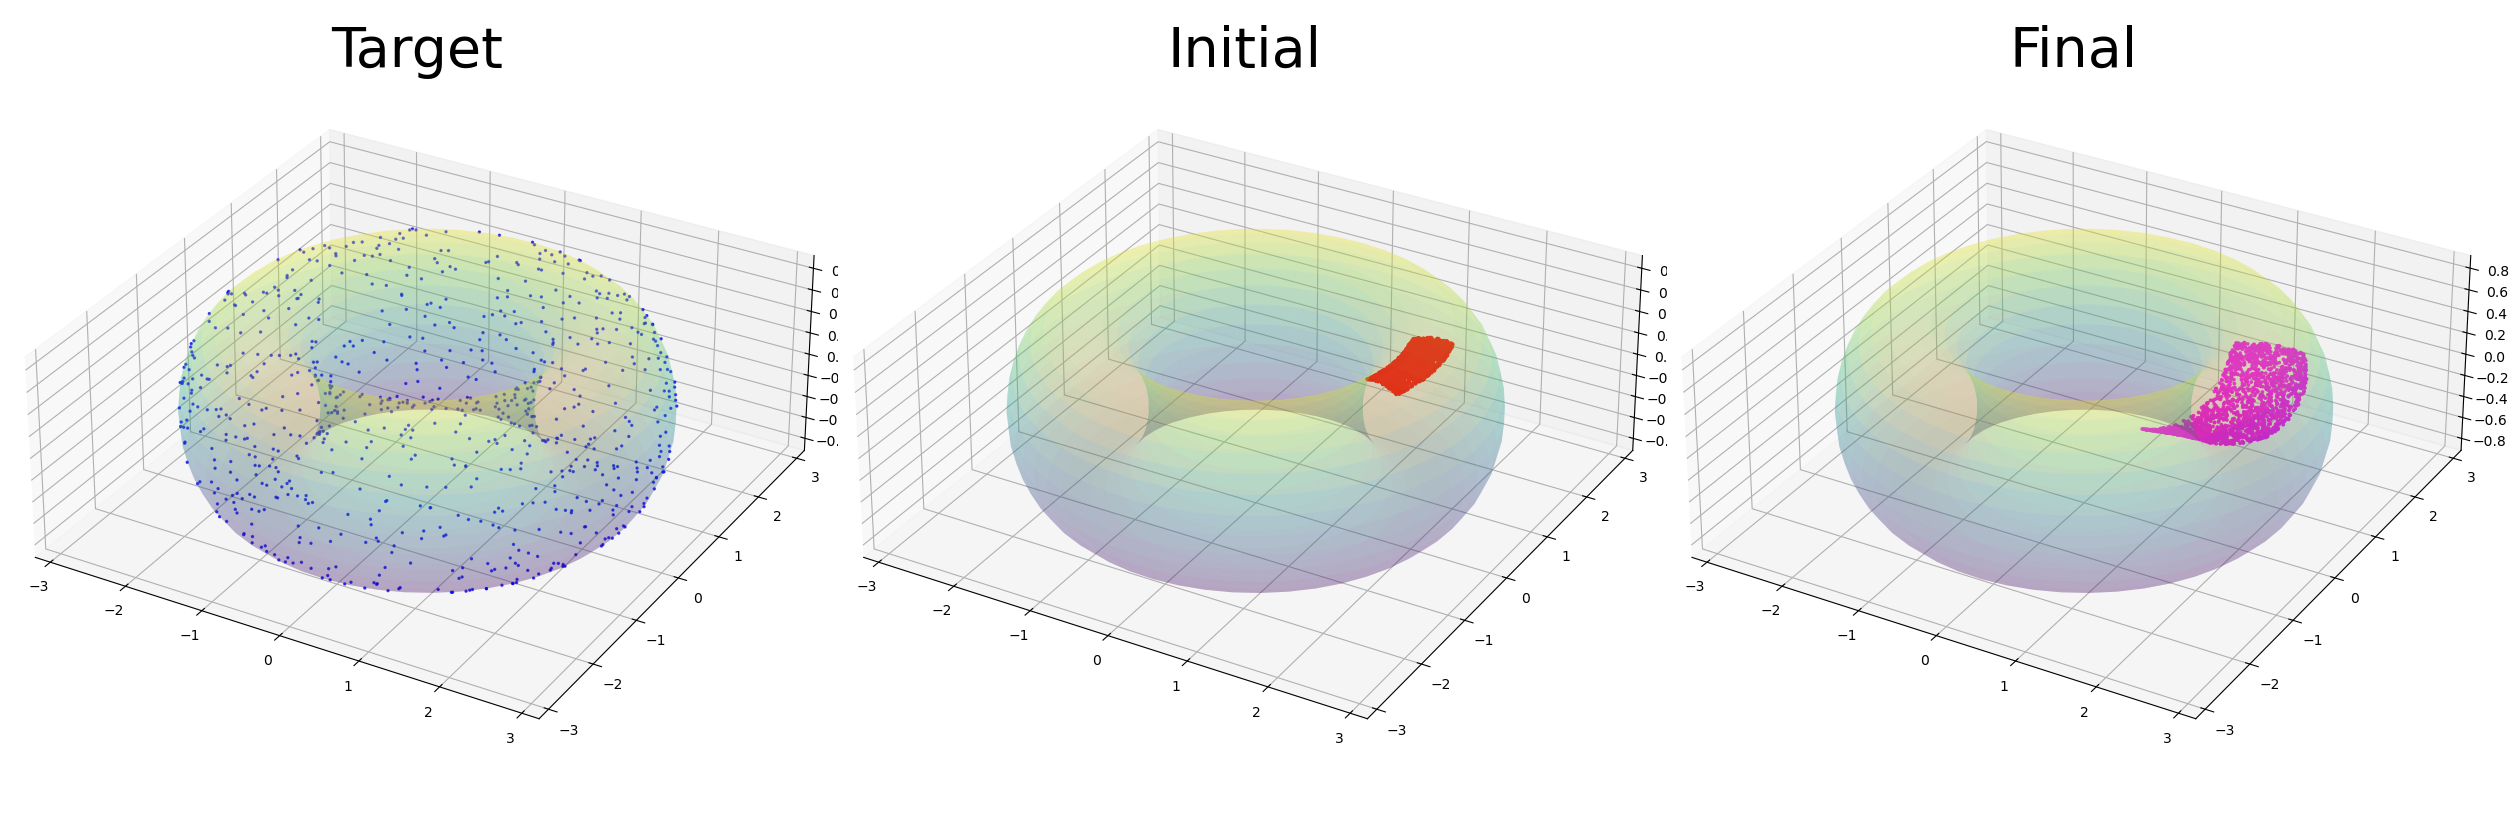

In [39]:
# ============ Save static figures as PDF (vector format for LaTeX) ============
# Matplotlib static figures for paper
fig_pdf, axes_pdf = plt.subplots(1, 3, figsize=(25, 10), subplot_kw={'projection': '3d'})

# Target
axes_pdf[0].plot_surface(X_surf, Y_surf, Z_surf, alpha=0.2, cmap='viridis', edgecolor='none')
axes_pdf[0].scatter(X_tar[:, 0], X_tar[:, 1], X_tar[:, 2], s=2, c='blue', alpha=0.7)
axes_pdf[0].set_title('Target', fontsize=40, y=1.0)
axes_pdf[0].set_box_aspect([1, 1, 0.4])

# Initial
axes_pdf[1].plot_surface(X_surf, Y_surf, Z_surf, alpha=0.2, cmap='viridis', edgecolor='none')
axes_pdf[1].scatter(x_t[:, 0, 0], x_t[:, 1, 0], x_t[:, 2, 0], s=3, c='red', alpha=0.9)
axes_pdf[1].set_title('Initial', fontsize=40, y=1.0)
axes_pdf[1].set_box_aspect([1, 1, 0.4])

# Final
axes_pdf[2].plot_surface(X_surf, Y_surf, Z_surf, alpha=0.2, cmap='viridis', edgecolor='none')
axes_pdf[2].scatter(x_t[:, 0, -1], x_t[:, 1, -1], x_t[:, 2, -1], s=3, c='magenta', alpha=0.9)
axes_pdf[2].set_title('Final', fontsize=40, y=1.0)
axes_pdf[2].set_box_aspect([1, 1, 0.4])

# plt.suptitle('DMPS on Torus T²', fontsize=22, y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('figures/torus/dmps_torus_results.pdf', dpi=300, bbox_inches='tight')
plt.savefig('figures/torus/dmps_torus_results.png', dpi=300, bbox_inches='tight')
print("[SAVED] figures/torus/dmps_torus_results.pdf (vector format for LaTeX)")
print("[SAVED] figures/torus/dmps_torus_results.png (raster format)")
plt.show()

## 12. Angular Coordinate Analysis

Visualize how particles spread in $(\theta, \phi)$ coordinates.

Saved: figures/torus/dmps_4_angular_coordinates.pdf/.png


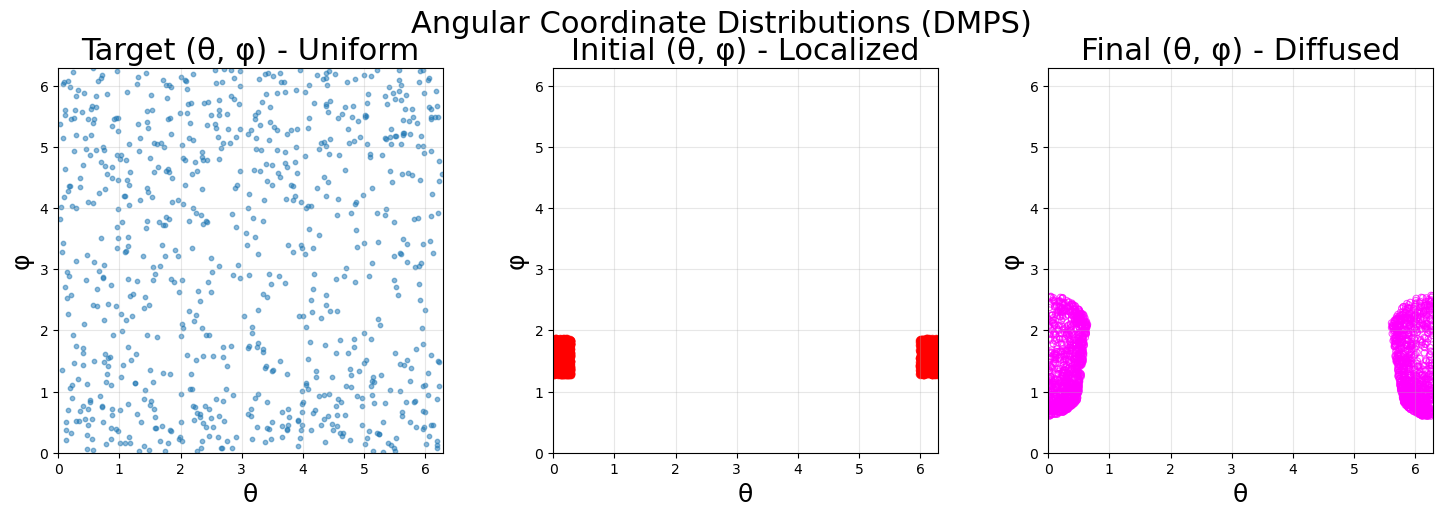


[SPREAD ANALYSIS]
Initial θ: mean=3.225, std=2.996
Final θ:   mean=3.106, std=2.824
Initial φ: mean=1.573, std=0.174
Final φ:   mean=1.428, std=0.557


In [40]:
# Convert initial and final positions to angular coordinates
theta_init_final, phi_init_final = cartesian_to_angles(x_t[:, :, 0], R, r)
theta_final, phi_final = cartesian_to_angles(x_t[:, :, -1], R, r)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Target distribution in angular coordinates
axes[0].scatter(theta_tar, phi_tar, s=10, c='C0', alpha=0.5)
axes[0].set_xlabel('θ', fontsize=18)
axes[0].set_ylabel('φ', fontsize=18)
axes[0].set_title('Target (θ, φ) - Uniform', fontsize=22)
axes[0].set_xlim(0, 2*np.pi)
axes[0].set_ylim(0, 2*np.pi)
axes[0].set_aspect('equal')
axes[0].grid(True, alpha=0.3)

# Initial distribution in angular coordinates
axes[1].scatter(theta_init_final, phi_init_final, s=20, c='red', alpha=0.7)
axes[1].set_xlabel('θ', fontsize=18)
axes[1].set_ylabel('φ', fontsize=18)
axes[1].set_title('Initial (θ, φ) - Localized', fontsize=22)
axes[1].set_xlim(0, 2*np.pi)
axes[1].set_ylim(0, 2*np.pi)
axes[1].set_aspect('equal')
axes[1].grid(True, alpha=0.3)

# Final distribution in angular coordinates
axes[2].scatter(theta_final, phi_final, s=20, facecolors='none', edgecolors='magenta', linewidths=0.8, alpha=0.7)
axes[2].set_xlabel('θ', fontsize=18)
axes[2].set_ylabel('φ', fontsize=18)
axes[2].set_title('Final (θ, φ) - Diffused', fontsize=22)
axes[2].set_xlim(0, 2*np.pi)
axes[2].set_ylim(0, 2*np.pi)
axes[2].set_aspect('equal')
axes[2].grid(True, alpha=0.3)

plt.suptitle('Angular Coordinate Distributions (DMPS)', fontsize=22)
plt.tight_layout()
plt.savefig('figures/torus/dmps_4_angular_coordinates.pdf', dpi=300, bbox_inches='tight')
plt.savefig('figures/torus/dmps_4_angular_coordinates.png', dpi=300, bbox_inches='tight')
print("Saved: figures/torus/dmps_4_angular_coordinates.pdf/.png")
plt.show()

# Compute spread statistics
print("\n[SPREAD ANALYSIS]")
print(f"Initial θ: mean={np.mean(theta_init_final):.3f}, std={np.std(theta_init_final):.3f}")
print(f"Final θ:   mean={np.mean(theta_final):.3f}, std={np.std(theta_final):.3f}")
print(f"Initial φ: mean={np.mean(phi_init_final):.3f}, std={np.std(phi_init_final):.3f}")
print(f"Final φ:   mean={np.mean(phi_final):.3f}, std={np.std(phi_final):.3f}")

## 13. Radius Analysis

Check if particles stay on the torus surface.

Saved: figures/torus/dmps_5_radius_analysis.pdf/.png


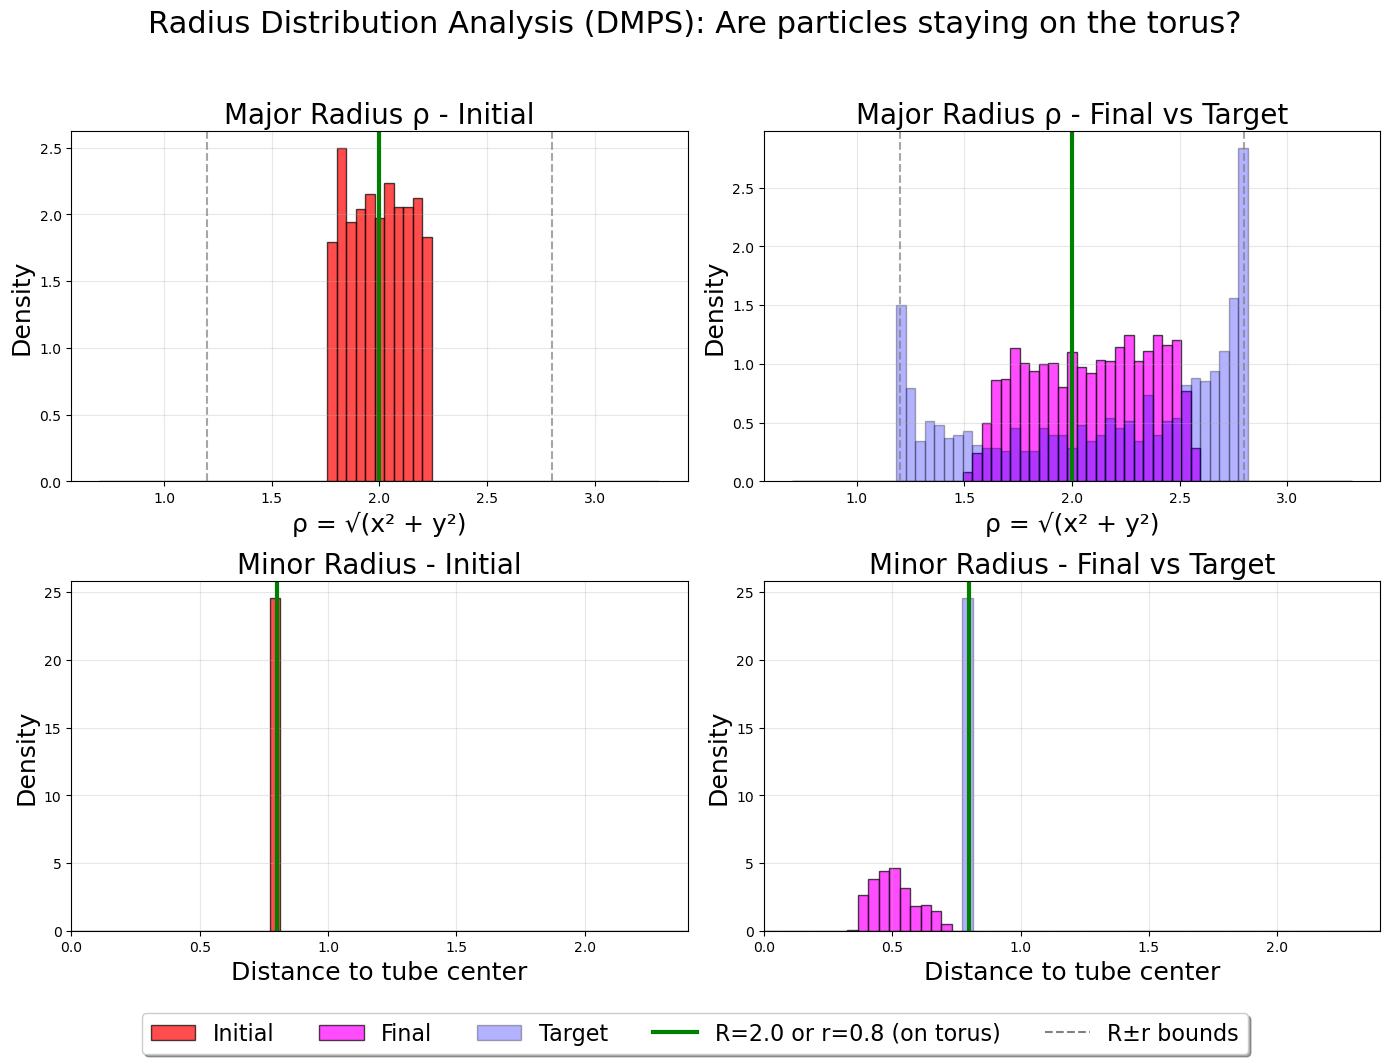


[RADIUS ANALYSIS] - Key metric: do particles stay on torus surface?

1. Major radius ρ = √(x²+y²) [distance from z-axis]:
   On torus surface: ρ ∈ [R-r, R+r] = [1.20, 2.80]
   Initial (φ≈π/2 → ρ≈R): mean=1.9981, std=0.1378
   Final:                  mean=2.0895, std=0.2805
   Target:                 mean=2.1614, std=0.5509

2. Minor radius [distance to tube center]:
   On torus surface: dist = r = 0.80 (exactly!)
   Initial:  mean=0.8000, std=0.000000
   Final:    mean=0.5099, std=0.0859
   Target:   mean=0.8000, std=0.000000

[TORUS CHECK]
   Initial particles off torus (|dist-r|>0.01): 0/2000 (0.0%)
   Final particles off torus (|dist-r|>0.1):    1971/2000 (98.5%)


In [41]:
# ============ Figure 4: Radius Analysis ============
# Compute radii for initial and final positions
# Major radius ρ = sqrt(x² + y²) is distance from z-axis
# Minor radius = distance from tube center (should be exactly r on torus surface)

# Initial positions
x_init_pos = x_t[:, 0, 0]
y_init_pos = x_t[:, 1, 0]
z_init_pos = x_t[:, 2, 0]
rho_init = np.sqrt(x_init_pos**2 + y_init_pos**2)  # Distance from z-axis (major radius)
dist_to_tube_center_init = np.sqrt((rho_init - R)**2 + z_init_pos**2)  # Minor radius

# Final positions
x_final_pos = x_t[:, 0, -1]
y_final_pos = x_t[:, 1, -1]
z_final_pos = x_t[:, 2, -1]
rho_final = np.sqrt(x_final_pos**2 + y_final_pos**2)  # Distance from z-axis (major radius)
dist_to_tube_center_final = np.sqrt((rho_final - R)**2 + z_final_pos**2)  # Minor radius

# Target positions for reference
rho_tar = np.sqrt(X_tar[:, 0]**2 + X_tar[:, 1]**2)
dist_to_tube_center_tar = np.sqrt((rho_tar - R)**2 + X_tar[:, 2]**2)

# Create 2x2 figure for radius distributions with extra space at bottom for legend
fig_rad, axes_rad = plt.subplots(2, 2, figsize=(14, 11))

# ===== Row 1: Major radius ρ (distance from z-axis) =====
rho_bins = np.linspace(R - r - 0.5, R + r + 0.5, 60)

# Plot 1: Major radius ρ - Initial (should be delta-like at ρ≈R since φ≈π/2)
axes_rad[0, 0].hist(rho_init, bins=rho_bins, color='red', alpha=0.7, edgecolor='black', density=True)
axes_rad[0, 0].axvline(R, color='green', linestyle='-', linewidth=3)
axes_rad[0, 0].axvline(R - r, color='gray', linestyle='--', linewidth=1.5, alpha=0.7)
axes_rad[0, 0].axvline(R + r, color='gray', linestyle='--', linewidth=1.5, alpha=0.7)
axes_rad[0, 0].set_xlabel('ρ = √(x² + y²)', fontsize=18)
axes_rad[0, 0].set_ylabel('Density', fontsize=18)
axes_rad[0, 0].set_title(f'Major Radius ρ - Initial', fontsize=20)
axes_rad[0, 0].grid(True, alpha=0.3)

# Plot 2: Major radius ρ - Final
axes_rad[0, 1].hist(rho_final, bins=rho_bins, color='magenta', alpha=0.7, edgecolor='black', density=True)
axes_rad[0, 1].hist(rho_tar, bins=rho_bins, color='blue', alpha=0.3, edgecolor='black', density=True)
axes_rad[0, 1].axvline(R, color='green', linestyle='-', linewidth=3)
axes_rad[0, 1].axvline(R - r, color='gray', linestyle='--', linewidth=1.5, alpha=0.7)
axes_rad[0, 1].axvline(R + r, color='gray', linestyle='--', linewidth=1.5, alpha=0.7)
axes_rad[0, 1].set_xlabel('ρ = √(x² + y²)', fontsize=18)
axes_rad[0, 1].set_ylabel('Density', fontsize=18)
axes_rad[0, 1].set_title(f'Major Radius ρ - Final vs Target', fontsize=20)
axes_rad[0, 1].grid(True, alpha=0.3)

# ===== Row 2: Minor radius (distance to tube center) =====
minor_bins = np.linspace(0, r * 3, 60)

# Plot 3: Minor radius - Initial (should be delta-like at r=0.8)
axes_rad[1, 0].hist(dist_to_tube_center_init, bins=minor_bins, color='red', alpha=0.7, edgecolor='black', density=True)
axes_rad[1, 0].axvline(r, color='green', linestyle='-', linewidth=3)
axes_rad[1, 0].set_xlabel('Distance to tube center', fontsize=18)
axes_rad[1, 0].set_ylabel('Density', fontsize=18)
axes_rad[1, 0].set_title(f'Minor Radius - Initial', fontsize=20)
axes_rad[1, 0].grid(True, alpha=0.3)
axes_rad[1, 0].set_xlim(0, r * 3)

# Plot 4: Minor radius - Final (should still be near r=0.8 if DMPS works)
axes_rad[1, 1].hist(dist_to_tube_center_final, bins=minor_bins, color='magenta', alpha=0.7, edgecolor='black', density=True)
axes_rad[1, 1].hist(dist_to_tube_center_tar, bins=minor_bins, color='blue', alpha=0.3, edgecolor='black', density=True)
axes_rad[1, 1].axvline(r, color='green', linestyle='-', linewidth=3)
axes_rad[1, 1].set_xlabel('Distance to tube center', fontsize=18)
axes_rad[1, 1].set_ylabel('Density', fontsize=18)
axes_rad[1, 1].set_title(f'Minor Radius - Final vs Target', fontsize=20)
axes_rad[1, 1].grid(True, alpha=0.3)
axes_rad[1, 1].set_xlim(0, r * 3)

# Create shared legend at bottom
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
legend_elements = [
    Patch(facecolor='red', alpha=0.7, edgecolor='black', label='Initial'),
    Patch(facecolor='magenta', alpha=0.7, edgecolor='black', label='Final'),
    Patch(facecolor='blue', alpha=0.3, edgecolor='black', label='Target'),
    Line2D([0], [0], color='green', linewidth=3, label=f'R={R:.1f} or r={r:.1f} (on torus)'),
    Line2D([0], [0], color='gray', linestyle='--', linewidth=1.5, label=f'R±r bounds'),
]
fig_rad.legend(handles=legend_elements, loc='lower center', ncol=5, fontsize=16, 
               bbox_to_anchor=(0.5, 0.02), frameon=True, fancybox=True, shadow=True)

plt.suptitle('Radius Distribution Analysis (DMPS): Are particles staying on the torus?', fontsize=22, y=0.98)
plt.tight_layout(rect=[0, 0.08, 1, 0.95])
plt.savefig('figures/torus/dmps_5_radius_analysis.pdf', dpi=300, bbox_inches='tight')
plt.savefig('figures/torus/dmps_5_radius_analysis.png', dpi=300, bbox_inches='tight')
print("Saved: figures/torus/dmps_5_radius_analysis.pdf/.png")
plt.show()

# Print radius statistics
print("\n[RADIUS ANALYSIS] - Key metric: do particles stay on torus surface?")
print(f"\n1. Major radius ρ = √(x²+y²) [distance from z-axis]:")
print(f"   On torus surface: ρ ∈ [R-r, R+r] = [{R-r:.2f}, {R+r:.2f}]")
print(f"   Initial (φ≈π/2 → ρ≈R): mean={np.mean(rho_init):.4f}, std={np.std(rho_init):.4f}")
print(f"   Final:                  mean={np.mean(rho_final):.4f}, std={np.std(rho_final):.4f}")
print(f"   Target:                 mean={np.mean(rho_tar):.4f}, std={np.std(rho_tar):.4f}")

print(f"\n2. Minor radius [distance to tube center]:")
print(f"   On torus surface: dist = r = {r:.2f} (exactly!)")
print(f"   Initial:  mean={np.mean(dist_to_tube_center_init):.4f}, std={np.std(dist_to_tube_center_init):.6f}")
print(f"   Final:    mean={np.mean(dist_to_tube_center_final):.4f}, std={np.std(dist_to_tube_center_final):.4f}")
print(f"   Target:   mean={np.mean(dist_to_tube_center_tar):.4f}, std={np.std(dist_to_tube_center_tar):.6f}")

# Check if particles flew off the torus
off_torus_init = np.sum(np.abs(dist_to_tube_center_init - r) > 0.01)
off_torus_final = np.sum(np.abs(dist_to_tube_center_final - r) > 0.1)

print(f"\n[TORUS CHECK]")
print(f"   Initial particles off torus (|dist-r|>0.01): {off_torus_init}/{m} ({100*off_torus_init/m:.1f}%)")
print(f"   Final particles off torus (|dist-r|>0.1):    {off_torus_final}/{m} ({100*off_torus_final/m:.1f}%)")

## 14. Scatter Matrix Analysis

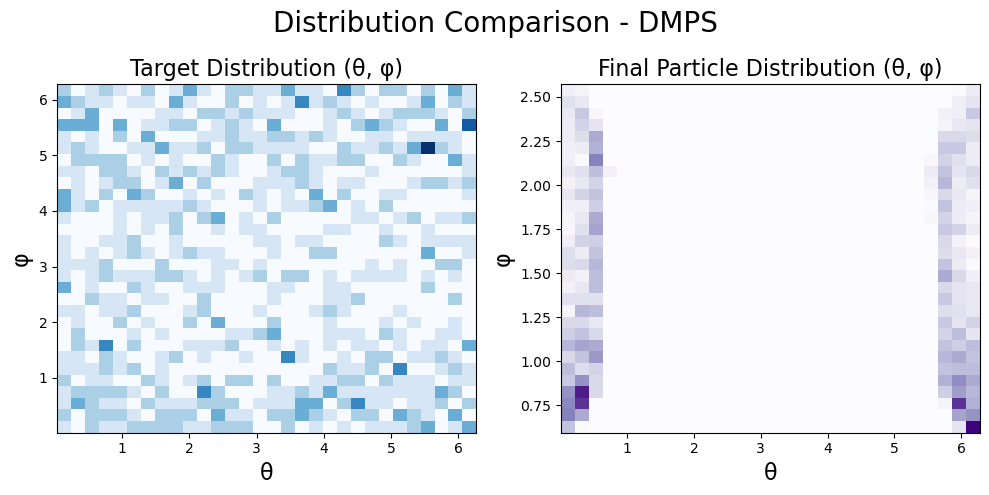

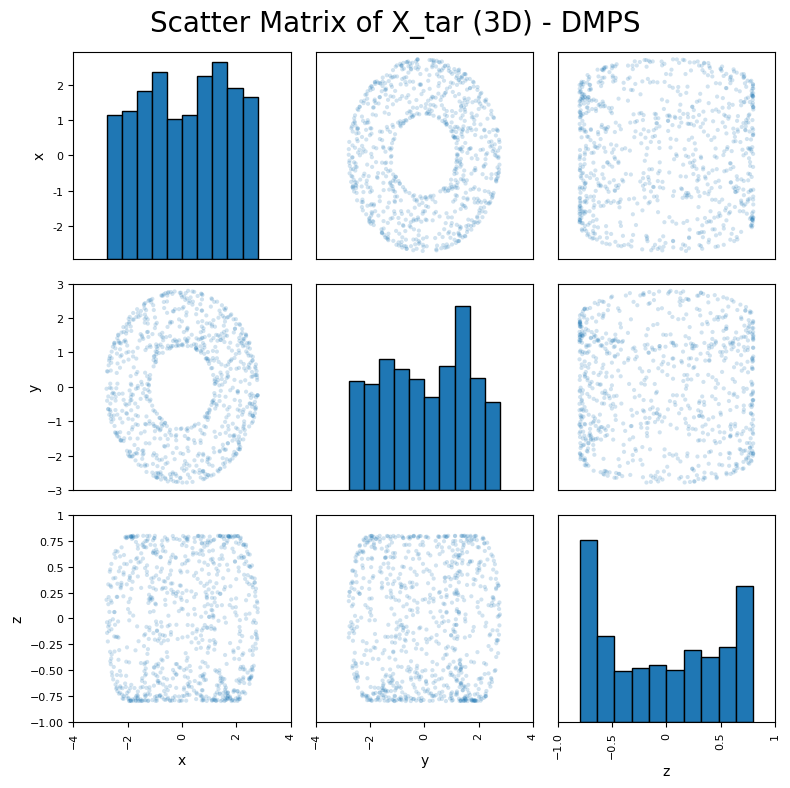

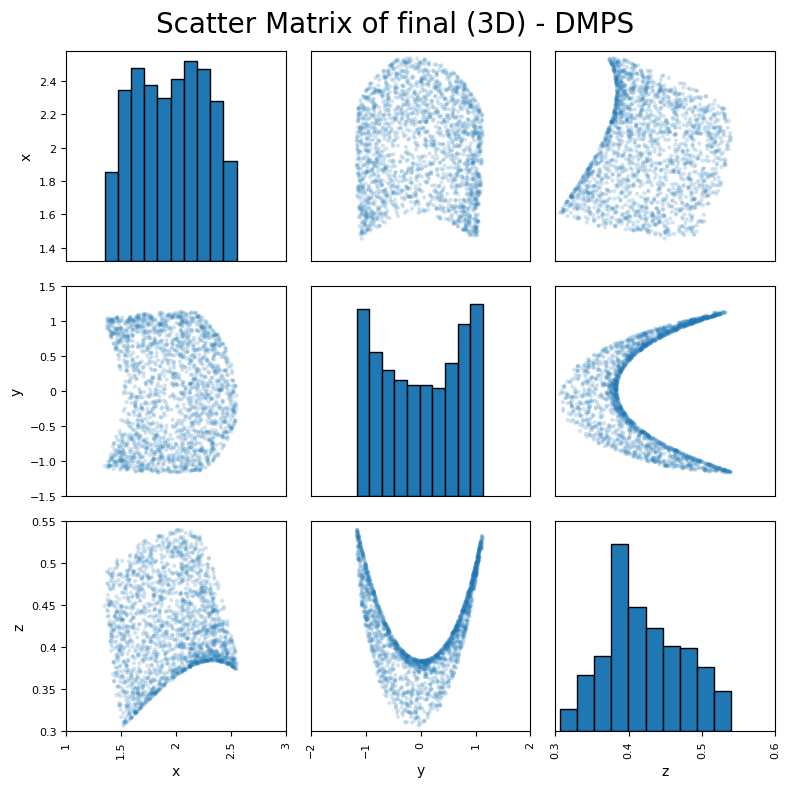

[SAVED] figures/torus/dmps_overlapping_scatter_matrix.pdf & .png


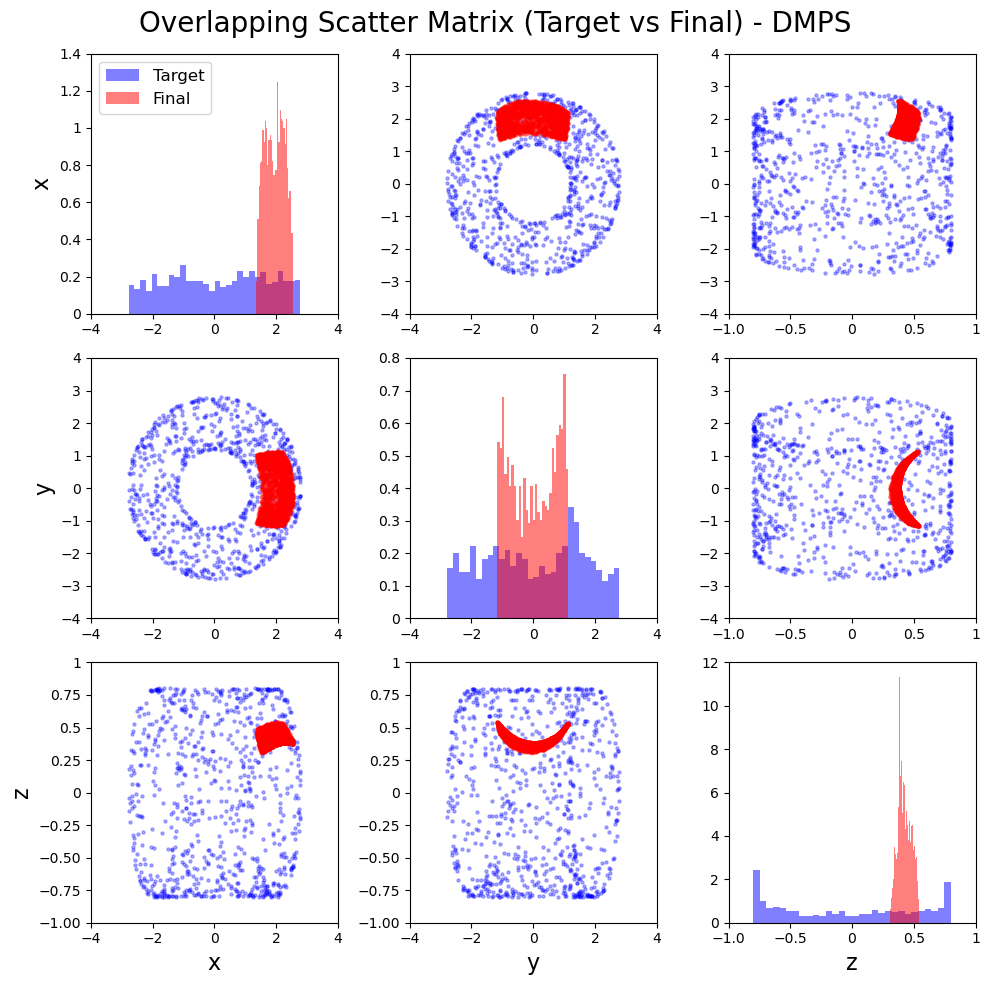

In [78]:
# Fixed figure sizes for consistent output
FIGSIZE_2PANEL = (10, 5)
FIGSIZE_SCATTER_MATRIX = (8, 8)
FIGSIZE_OVERLAP_MATRIX = (10, 10)

fig, axes = plt.subplots(1, 2, figsize=FIGSIZE_2PANEL)
fig.set_size_inches(FIGSIZE_2PANEL, forward=True)

# Target distribution histogram
axes[0].hist2d(theta_tar, phi_tar, bins=30, cmap='Blues')
axes[0].set_xlabel('θ', fontsize=16)
axes[0].set_ylabel('φ', fontsize=16)
axes[0].set_title('Target Distribution (θ, φ)', fontsize=16)

# Final particle distribution histogram
axes[1].hist2d(theta_final, phi_final, bins=30, cmap='Purples')
axes[1].set_xlabel('θ', fontsize=16)
axes[1].set_ylabel('φ', fontsize=16)
axes[1].set_title('Final Particle Distribution (θ, φ)', fontsize=16)

plt.suptitle(f'Distribution Comparison - DMPS', fontsize=20)
plt.tight_layout()
plt.show()

# Helper function to clean up tick labels (remove trailing zeros)
def clean_tick_labels(ax):
    """Remove trailing zeros from tick labels without changing tick positions."""
    import warnings
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        
        # Clean x-axis labels
        xticks = ax.get_xticks()
        xlabels = [item.get_text() for item in ax.get_xticklabels()]
        cleaned_xlabels = []
        for label in xlabels:
            if label:
                try:
                    val = float(label)
                    cleaned = f'{val:.10f}'.rstrip('0').rstrip('.')
                    cleaned_xlabels.append(cleaned)
                except:
                    cleaned_xlabels.append(label)
            else:
                cleaned_xlabels.append(label)
        ax.set_xticks(xticks)
        ax.set_xticklabels(cleaned_xlabels)
        
        # Clean y-axis labels
        yticks = ax.get_yticks()
        ylabels = [item.get_text() for item in ax.get_yticklabels()]
        cleaned_ylabels = []
        for label in ylabels:
            if label:
                try:
                    val = float(label)
                    cleaned = f'{val:.10f}'.rstrip('0').rstrip('.')
                    cleaned_ylabels.append(cleaned)
                except:
                    cleaned_ylabels.append(label)
            else:
                cleaned_ylabels.append(label)
        ax.set_yticks(yticks)
        ax.set_yticklabels(cleaned_ylabels)

# 3D scatter matrices with cleaned labels
axes_sm1 = pd.plotting.scatter_matrix(
    pd.DataFrame(X_tar, columns=['x', 'y', 'z']),
    alpha=0.2,
    figsize=FIGSIZE_SCATTER_MATRIX,
    diagonal='hist',
    hist_kwds={'edgecolor': 'black'}
)
# Clean up tick labels
for ax_row in axes_sm1:
    for ax in ax_row:
        clean_tick_labels(ax)
plt.gcf().set_size_inches(FIGSIZE_SCATTER_MATRIX, forward=True)
plt.suptitle(f'Scatter Matrix of X_tar (3D) - DMPS', fontsize=20)
plt.tight_layout()
plt.show()

# Scatter matrix for final positions
axes_sm2 = pd.plotting.scatter_matrix(
    pd.DataFrame(x_t[:, :, -1], columns=['x', 'y', 'z']),
    alpha=0.2,
    figsize=FIGSIZE_SCATTER_MATRIX,
    diagonal='hist',
    hist_kwds={'edgecolor': 'black'}
)
# Clean up tick labels
for ax_row in axes_sm2:
    for ax in ax_row:
        clean_tick_labels(ax)
plt.gcf().set_size_inches(FIGSIZE_SCATTER_MATRIX, forward=True)
plt.suptitle(f'Scatter Matrix of final (3D) - DMPS', fontsize=20)
plt.tight_layout()
plt.show()

# Overlapping 3x3 scatter matrix comparison
fig, axes = plt.subplots(3, 3, figsize=FIGSIZE_OVERLAP_MATRIX)
fig.set_size_inches(FIGSIZE_OVERLAP_MATRIX, forward=True)
columns = ['x', 'y', 'z']
df_tar = pd.DataFrame(X_tar, columns=columns)
df_final = pd.DataFrame(x_t[:, :, -1], columns=columns)

for i in range(3):
    for j in range(3):
        ax = axes[i, j]
        if i == j:
            # Diagonal: overlapping histograms
            ax.hist(df_tar[columns[i]], bins=30, alpha=0.5, color='blue', label='Target', density=True)
            ax.hist(df_final[columns[i]], bins=30, alpha=0.5, color='red', label='Final', density=True)
            if i == 0:
                ax.legend(fontsize=12)
        else:
            # Off-diagonal: overlapping scatter plots
            ax.scatter(df_tar[columns[j]], df_tar[columns[i]], alpha=0.3, color='blue', s=5, label='Target')
            ax.scatter(df_final[columns[j]], df_final[columns[i]], alpha=0.3, color='red', s=5, label='Final')
        
        # Clean up tick labels
        clean_tick_labels(ax)
        
        if i == 2:
            ax.set_xlabel(columns[j], fontsize=16)
        if j == 0:
            ax.set_ylabel(columns[i], fontsize=16)

plt.suptitle(f'Overlapping Scatter Matrix (Target vs Final) - DMPS', fontsize=20)
plt.tight_layout()
plt.savefig('figures/torus/dmps_overlapping_scatter_matrix.pdf', dpi=300, bbox_inches='tight')
plt.savefig('figures/torus/dmps_overlapping_scatter_matrix.png', dpi=300, bbox_inches='tight')
print("[SAVED] figures/torus/dmps_overlapping_scatter_matrix.pdf & .png")
plt.show()
